# MBIO 610 Final Modeling Project

Github page for data processing found [here](https://github.com/dbarnas/MBIO_610_Modeling_Project/tree/main/Data)

Project goal: Model the competition between stony coral and macroalgae+turf along a reef experiencing submarine groundwater discharge (SGD)

In [1]:
## IMPORT LIBRARIES
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import rc
import seaborn as sns
import pandas as pd
from scipy import stats
from scipy.optimize import curve_fit
from scipy.integrate import odeint
from scipy.integrate import solve_ivp

Initial assumptions for super simplicity for starters:
- No intraspecific competition (w/n coral or macroalgae+turf (for now)
- Interspecific competition (b/n coral and macroalgae+turf
- Macroalgae and turf are comparable enough to bring into single functional group (for now)
- Carrying capacity $K$ is 1.0 (or 100%) for both Coral and MA+T (denoted as M) groups in the absence of a second group
- MA+T intrinsic growth rate > Coral growth rate
- MA+T and Coral proportional cover shift over an SGD gradient and are covaried along reef ($R^2 = 0.69$, $p = 3e-11$)
- No mortality outside of competition and environmental impact factor (for now)

### Follow a 2-species competition model with the inclusion of an environmental factor impacting both species differently:
Typical 2-species competition model:
$$\frac{\delta C}{\delta t} = \frac{r_C C}{K_C}(K_C - C - \alpha_{C,M} M)$$ 
(1)
$$\frac{\delta M}{\delta t} = \frac{r_M M}{K_M}(K_M - M - \alpha_{M,C} C)$$

Typical 2-species competition model including an environmental factor (n) impacting both species differently:  
(where $n_i > 0$ has a negative impact on species i, and $n_i < 0$ has a positive impact on species i)
$$\frac{\delta C}{\delta t} = \frac{r_C C}{K_C}(K_C - C - \alpha_{C,M} M - K_C n_C C)$$ 
(2)
$$\frac{\delta M}{\delta t} = \frac{r_M M}{K_M}(K_M - M - \alpha_{M,C} C - K_M n_M M)$$
$$r_C < r_M$$

In [ ]:
# Mumby et al. 2007 example
# Define a function to calculate the derivative
def Mumby(t, N, r, a, mu, gamma, g):
    C,M = N
    return [r*C*(1-C-M) - a*C*M - mu*C, gamma*M*(1-C-M) + a*C*M - g*M/(1-C)]


In [4]:
# Based on my equations in (2)
def sgdcompetition(t, N, rC, rM, aC, aM, K, nC, nM):
    C,M = N
    return [(rC*C/K)*(K-C-aC*M-K*nC*C), (rM*M/K)*(K-M-aM*C-K*nM*M)]

In [35]:
# set parameters for testing
rC = 0.2 #coral growth
rM = 0.4 #algae growth

aC = 0.2 #algal impact onto coral
aM = 0.2 #coral impact onto algae

nC = 0 #1.5 #coral impact from sgd
nM = 0 #0.5 #algae impact from sgd

K = 1.0 #max carrying capacity for coral and algae in the absence of second group

time_steps = 100 #no. of time steps
start = 0 
stop = 100
time_points = np.linspace(start, stop, time_steps+1)

In [36]:
# Initial conditions
# In the mumby parameter space, you should observe bistability or alternative stable states
# Let's see what we get with my model
# The results of competition will depend on initial conditions

# at lowest phosphate and Nitrate+Nitrite levels, pops start at ~50% each
C0 = 0.5
M0 = 0.5

sol = solve_ivp(sgdcompetition, [start,stop], [C0,M0], method='RK45', args=(rC,rM, aC,aM, K, nC,nM), dense_output=True)
N = sol.sol(time_points)

### Plot Coral and Macroalgae+Turf trajectories over time (with no sgd impact factor)

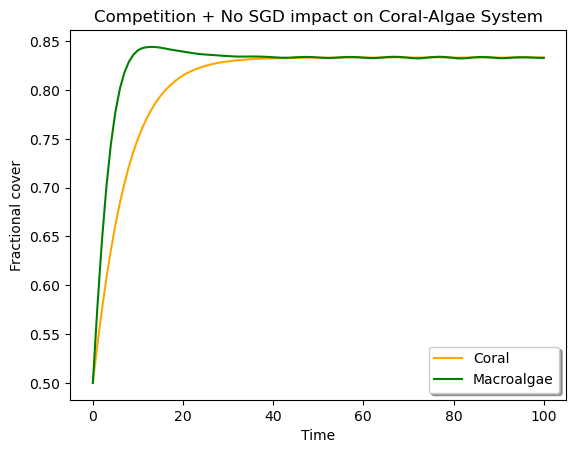

In [37]:
coral = N[0,:]
macroalgae = N[1,:]
plt.plot(time_points, coral, color='orange')
plt.plot(time_points, macroalgae, color='green')
plt.xlabel('Time')
plt.ylabel('Fractional cover')
plt.legend(['Coral', 'Macroalgae'], shadow=True)
plt.title('Competition + No SGD impact on Coral-Algae System')
plt.show()

### Plot Coral and Macroalgae+Turf trajectories over time (with constant sgd impact factor)

In [38]:
# set parameters for testing
rC = 0.2 #coral growth
rM = 0.4 #algae growth

aC = 0.2 #algal impact onto coral
aM = 0.2 #coral impact onto algae

nC = 1.5 #coral impact from sgd (dummy factors for phosphate impact)
nM = 0.5 #algae impact from sgd 

K = 1.0 #max carrying capacity for coral and algae in the absence of second group

time_steps = 100 #no. of time steps
start = 0 
stop = 100
time_points = np.linspace(start, stop, time_steps+1)

In [39]:
# Initial conditions
# at lowest phosphate and Nitrate+Nitrite levels, pops start at ~50% each
C0 = 0.5
M0 = 0.5

sol = solve_ivp(sgdcompetition, [start,stop], [C0,M0], method='RK45', args=(rC,rM, aC,aM, K, nC,nM), dense_output=True)
N = sol.sol(time_points)

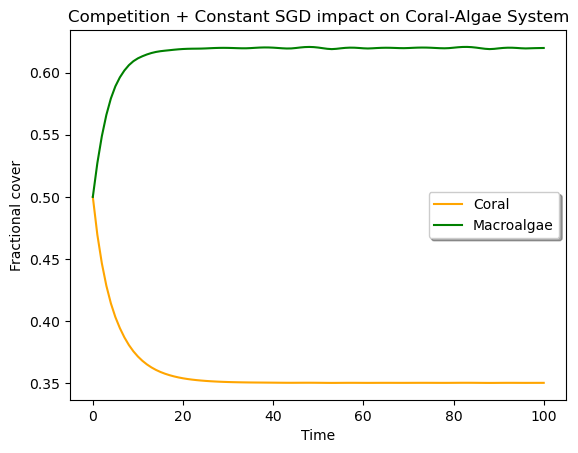

In [40]:
coral = N[0,:]
macroalgae = N[1,:]
plt.plot(time_points, coral, color='orange')
plt.plot(time_points, macroalgae, color='green')
plt.xlabel('Time')
plt.ylabel('Fractional cover')
plt.legend(['Coral', 'Macroalgae'], shadow=True)
plt.title('Competition + Constant SGD impact on Coral-Algae System')
plt.show()

## Part 2: Analyze the system using a DIY numerical solver - 2 numerical integration methods

In [ ]:
# Mumby et al. 2007 example
def dNdt(C,M,P):
    
    dt = P['dt']
    
    #! Calculate the derivative
    dC = (r*C*(1-C-M) - a*C*M - mu*C) * dt #Coral equation
    dM = (gamma*M*(1-C-M) + a*C*M - g*M/(1-C)) * dt #Macroalgae equation

    return dC, dM

In [41]:
# My model:
def dNdt(C,M,P):
    
    dt = P['dt']
    
    # Calculate the derivative
    dC = (rC*C/K)*(K-C-aC*M-K*nC*C) * dt #Coral equation
    dM = (rM*M/K)*(K-M-aM*C-K*nM*M) * dt #Macroalgae equation
    
    return dC, dM

### Function to calculate the next value of C & M using the Euler method

Euler's method is based on taking successive linear approximations to the solution.

In [ ]:
# Mumby et al. 2007 example:
def Euler(C,M,P): #Euler
    
    C_init = C
    M_init = M
    
    dC, dM = dNdt(C,M,P)
    
    C = C + dC
    M = M + dM
    
    return C, M

In [42]:
# My model:
# currently copying Mumby's example:
def Euler(C,M,P): #Euler
    
    C_init = C
    M_init = M
    
    dC, dM = dNdt(C,M,P)
    
    C = C + dC
    M = M + dM
    
    return C, M

### Function to calculate the next value of C & M using the 2nd order Runge-Kutta method

In [ ]:
# Mumby et al. 2007 example (multiple kernels below)
def RK2(C,M,P): #2nd-order Runge-Kutta
    
    C_init = C
    M_init = M
    
    dC1, dM1 = dNdt(C,M,P)
    
    C1 = C + 0.5*dC1 # what is the 0.5 value from??
    M1 = M + 0.5*dM1
    
    dC2, dM2 = dNdt(C1,M1,P)
    
    dCave = (dC1 + dC2)/2
    dMave = (dM1 + dM2)/2
    
    C = C_init + dCave
    M = M_init + dMave
    
    return C, M


def run_model_RK2(INIT_C,INIT_M,P):
   
    NUMSTEPS = P['NUMSTEPS']
    
    C = np.zeros((NUMSTEPS))
    M = np.zeros((NUMSTEPS))
    
    C[0] = INIT_C
    M[0] = INIT_M
    
    for step in np.arange(0,NUMSTEPS-1):
        C[step+1],M[step+1] = RK2(C[step],M[step],P)
    
    return C, M


def run_model_Euler(INIT_C,INIT_M,P):
   
    NUMSTEPS = P['NUMSTEPS']
    
    C = np.zeros((NUMSTEPS))
    M = np.zeros((NUMSTEPS))
    
    C[0] = INIT_C
    M[0] = INIT_M
    
    for step in np.arange(0,NUMSTEPS-1):
        C[step+1],M[step+1] = Euler(C[step],M[step],P)
    
    return C, M

In [ ]:
# Set parameter values
r = 0.2 #coral growth
a = 0.2 #algal overgrowth onto coral
mu = 0.1 #coral background mortality
gamma = 0.7 #algal growth rate
g = 0.3 #maximum grazing rate
dt = 0.1 #step size
NUMYEARS = 100
NUMSTEPS = int(NUMYEARS/dt)

# Create a dictionary object called 'parameters_dict'
parameters_dict = {'dt':dt,
                    'NUMSTEPS': NUMSTEPS, 
                    'r': r, 
                    'a': a,
                    'mu': mu,
                    'gamma': gamma,
                    'g': g
                    }

# set initial conditions for C0 and M0
C0 = 0.2
M0 = 0.2

# Generate output
C_array0, M_array0 = run_model_Euler(C0,M0,parameters_dict)
C_array1, M_array1 = run_model_RK2(C0,M0,parameters_dict)

In [ ]:
# Plot the results using the Forward Euler method
x_vals = np.linspace(0,NUMYEARS,NUMSTEPS)
plt.plot(x_vals, C_array0, c='purple')
plt.plot(x_vals, M_array0, c='green')
plt.legend(['coral', 'algae'], bbox_to_anchor=(1,0.5))
plt.title('[Euler] Max grazing rate (g) ='+ str(g));

In [ ]:
# Plot the results using the second order Runge-Kutta
x_vals = np.linspace(0,NUMYEARS,NUMSTEPS)
plt.plot(x_vals, C_array1, c='purple')
plt.plot(x_vals, M_array1, c='green')
plt.legend(['coral', 'algae'], bbox_to_anchor=(1,0.5))
plt.title('[Runge-Kutta] Max grazing rate (g) ='+ str(g));

In [ ]:
fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(15,6))

for i in np.arange(0,100):
    C0 = np.random.random()
    M0 = np.random.random()
    # only use initial conditions that make sense, i.e. Initial Coral + Macroalgae must be less than 1
    if (C0 + M0 <= 1) : 
        C_array, M_array = run_model_RK2(C0,M0,parameters_dict)
        if (C_array[-1] > M_array[-1]): # if final coral value > final macroalgae value
            color = 'purple'
        else:
            color='green'
        ax1.plot(C_array, M_array, color=color, alpha=0.5) # plot the trajectory in the phase plane (plot A)
        item1 = ax1.scatter(C_array[0], M_array[0], color='blue', s=20, alpha=0.6) # plot the starting point in blue
        item2 = ax1.scatter(C_array[-1], M_array[-1], color='red', s=50) # plot the final point in red
        ax2.plot(C_array, c='purple', alpha=0.5) # plot the coral time series in plot B
        ax2.plot(M_array, c='green', alpha=0.5) # plot the macroalgae time series in plot B

ax1.legend([item1, item2], ['time step=0', 'time step=1000'], fontsize=14)
ax1.set_xlabel("Coral cover", fontsize=16);
ax1.set_ylabel("Macroalgae cover", fontsize=16);
ax1.tick_params(axis='x', labelsize=14)
ax1.tick_params(axis='y', labelsize=14)
ax1.set_title('Coral-Algal Phase Plane', fontsize=16)
ax1.set_xlim([-0.02,1])
ax1.set_ylim([-0.02,1])

ax2.legend(['Coral', 'Algae'], loc='lower left', bbox_to_anchor=(1.05, 0.7), fontsize=14)
ax2.tick_params(axis='x', labelsize=14)
ax2.tick_params(axis='y', labelsize=14)
ax2.set_xlabel("Time", fontsize=16);
ax2.set_ylabel("Relative abundance", fontsize=16);
ax2.set_title('Coral reef community dynamics', fontsize=16)

##### END OF MUMBY ET AL. 2007 EXAMPLE

In [85]:
# My model:
# currently copying Mumby's example:
def RK2(C,M,P): #2nd-order Runge-Kutta
    
    C_init = C
    M_init = M
    
    dC1, dM1 = dNdt(C,M,P)
    
    C1 = C + 0.5*dC1 # what is the 0.5 value from??
    M1 = M + 0.5*dM1
    
    dC2, dM2 = dNdt(C1,M1,P)
    
    dCave = (dC1 + dC2)/2
    dMave = (dM1 + dM2)/2
    
    C = C_init + dCave
    M = M_init + dMave
    
    return C, M


def run_model_RK2(INIT_C,INIT_M,P):
   
    NUMSTEPS = P['NUMSTEPS']
    
    C = np.zeros((NUMSTEPS))
    M = np.zeros((NUMSTEPS))
    
    C[0] = INIT_C
    M[0] = INIT_M
    
    for step in np.arange(0,NUMSTEPS-1):
        C[step+1],M[step+1] = RK2(C[step],M[step],P)
    
    return C, M


# def run_model_Euler(INIT_C,INIT_M,P):
   
#     NUMSTEPS = P['NUMSTEPS']
    
#     C = np.zeros((NUMSTEPS))
#     M = np.zeros((NUMSTEPS))
    
#     C[0] = INIT_C
#     M[0] = INIT_M
    
#     for step in np.arange(0,NUMSTEPS-1):
#         C[step+1],M[step+1] = Euler(C[step],M[step],P)
    
#     return C, M

In [86]:
# My model:
# Set parameter values for testing (using constant sgd impact factor)
rC = 0.2 #coral growth
rM = 0.4 #algae growth

aC = 0.2 #algal impact onto coral
aM = 0.2 #coral impact onto algae

nC = 1.5 #coral impact from sgd (dummy factors for phosphate impact)
nM = 0.5 #algae impact from sgd 

K = 1.0 #max carrying capacity for coral and algae in the absence of second group

dt = 0.1 #step size
NUMYEARS = 100
NUMSTEPS = int(NUMYEARS/dt)


# Create a dictionary object called 'parameters_dict'
parameters_dict = {'dt':dt,
                    'NUMSTEPS': NUMSTEPS, 
                    'rC': rC, 
                    'rM': rM,
                    'aC': aC,
                    'aM': aM,
                    'nC': nC,
                    'nM': nM,
                    'K': K
                    }

# set initial conditions for C0 and M0
C0 = 0.5
M0 = 0.5

# Generate output
#C_array0, M_array0 = run_model_Euler(C0,M0,parameters_dict)
C_array1, M_array1 = run_model_RK2(C0,M0,parameters_dict)

In [87]:
# # Plot the results using the Forward Euler method
# # copying code from Mumby example:
# x_vals = np.linspace(0,NUMYEARS,NUMSTEPS)
# plt.plot(x_vals, C_array0, c='orange')
# plt.plot(x_vals, M_array0, c='green')
# plt.legend(['coral', 'algae'], bbox_to_anchor=(1,0.5))
# plt.title('[Euler] SGD impact to coral (nC) = '+ 
#           '{0:.2f}'.format(nC) + # two decimal places only for string
#           ' and algae (nM) = ' + 
#           '{0:.2f}'.format(nM));

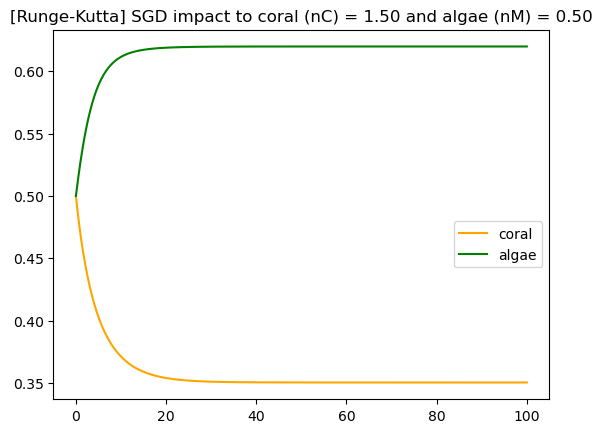

In [88]:
# Plot the results using the second order Runge-Kutta
# copying code from Mumby example:
x_vals = np.linspace(0,NUMYEARS,NUMSTEPS)
plt.plot(x_vals, C_array1, c='orange')
plt.plot(x_vals, M_array1, c='green')
plt.legend(['coral', 'algae'], bbox_to_anchor=(1,0.5))
plt.title('[Runge-Kutta] SGD impact to coral (nC) = '+ 
          '{0:.2f}'.format(nC) + # two decimal places only for string
          ' and algae (nM) = ' + 
          '{0:.2f}'.format(nM));

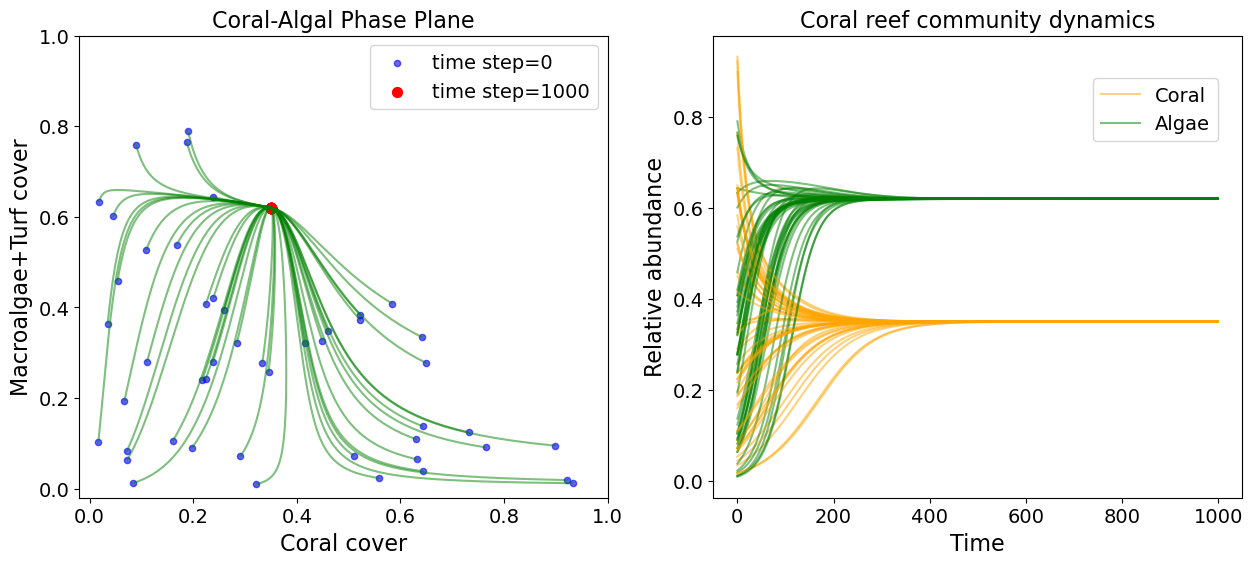

In [93]:
# for loop to create random INITIAL POPULATION SIZES for both C and M (0 < N < 1)
fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(15,6))

for i in np.arange(0,100):
    C0 = np.random.random()
    M0 = np.random.random()
    # only use initial conditions that make sense, i.e. Initial Coral + Macroalgae must be less than 1
    if (C0 + M0 <= 1) : 
        C_array, M_array = run_model_RK2(C0,M0,parameters_dict)
        if (C_array[-1] > M_array[-1]): # if final coral value > final macroalgae value
            color = 'orange'
        else:
            color='green'
        ax1.plot(C_array, M_array, color=color, alpha=0.5) # plot the trajectory in the phase plane (plot A)
        item1 = ax1.scatter(C_array[0], M_array[0], color='blue', s=20, alpha=0.6) # plot the starting point in blue
        item2 = ax1.scatter(C_array[-1], M_array[-1], color='red', s=50) # plot the final point in red
        ax2.plot(C_array, c='orange', alpha=0.5) # plot the coral time series in plot B
        ax2.plot(M_array, c='green', alpha=0.5) # plot the macroalgae time series in plot B

ax1.legend([item1, item2], ['time step=0', 'time step=1000'], fontsize=14)
ax1.set_xlabel("Coral cover", fontsize=16);
ax1.set_ylabel("Macroalgae+Turf cover", fontsize=16);
ax1.tick_params(axis='x', labelsize=14)
ax1.tick_params(axis='y', labelsize=14)
ax1.set_title('Coral-Algal Phase Plane', fontsize=16)
ax1.set_xlim([-0.02,1])
ax1.set_ylim([-0.02,1])

ax2.legend(['Coral', 'Algae'], loc='lower left', bbox_to_anchor=(0.70, 0.75), fontsize=14)
ax2.tick_params(axis='x', labelsize=14)
ax2.tick_params(axis='y', labelsize=14)
ax2.set_xlabel("Time", fontsize=16);
ax2.set_ylabel("Relative abundance", fontsize=16);
ax2.set_title('Coral reef community dynamics', fontsize=16);


#### Next, use the above for loop with an adaptation for changing the sgd parameter value

In [96]:
# My model:
# Set parameter values for testing (using constant sgd impact factor)
rC = 0.2 #coral growth
rM = 0.4 #algae growth

aC = 0.2 #algal impact onto coral
aM = 0.2 #coral impact onto algae

nC = 1.5 #coral impact from sgd (dummy factors for phosphate impact)
nM = 0.5 #algae impact from sgd 

K = 1.0 #max carrying capacity for coral and algae in the absence of second group

dt = 0.1 #step size
NUMYEARS = 100
NUMSTEPS = int(NUMYEARS/dt)


# Create a dictionary object called 'parameters_dict'
parameters_dict = {'dt':dt,
                    'NUMSTEPS': NUMSTEPS, 
                    'rC': rC, 
                    'rM': rM,
                    'aC': aC,
                    'aM': aM,
                    'nC': nC,
                    'nM': nM,
                    'K': K
                    }

# set initial conditions for C0 and M0
C0 = 0.5
M0 = 0.5

# Generate output
#C_array0, M_array0 = run_model_Euler(C0,M0,parameters_dict)
C_array1, M_array1 = run_model_RK2(C0,M0,parameters_dict) # will use RK2 for the for loop below

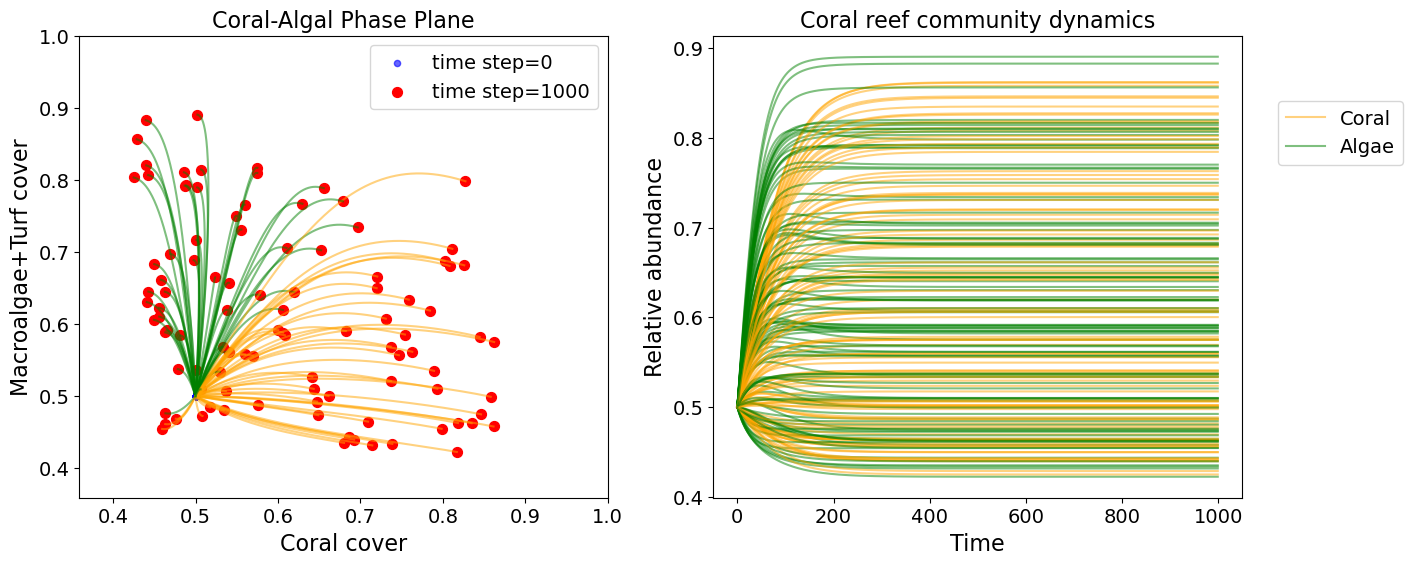

In [103]:
# for loop to create random initial population sizes for both C and M (0 < N < 1)
fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(15,6))

for i in np.arange(0,100):
    nC = np.random.random()
    nM = np.random.random()
    # only use initial conditions that make sense, though not yet sure what bounds to use on n
    #if (nC <= 1 & nM <= 1) :  # ignoring bounds for now
    C_array, M_array = run_model_RK2(C0,M0,parameters_dict)
    if (C_array[-1] > M_array[-1]): # if final coral value > final macroalgae value
        color = 'orange'
    else:
        color='green'
    ax1.plot(C_array, M_array, color=color, alpha=0.5) # plot the trajectory in the phase plane (plot A)
    item1 = ax1.scatter(C_array[0], M_array[0], color='blue', s=20, alpha=0.6) # plot the starting point in blue
    item2 = ax1.scatter(C_array[-1], M_array[-1], color='red', s=50) # plot the final point in red
    ax2.plot(C_array, c='orange', alpha=0.5) # plot the coral time series in plot B
    ax2.plot(M_array, c='green', alpha=0.5) # plot the macroalgae time series in plot B
    #ax3.plot(nC, c='orange', alpha = 0.5) # plot the coral time series in plot C
    #ax4.plot(nM, c='green', alpha = 0.5) # plot the macroalgae time series in plot C


ax1.legend([item1, item2], ['time step=0', 'time step=1000'], fontsize=14)
ax1.set_xlabel("Coral cover", fontsize=16);
ax1.set_ylabel("Macroalgae+Turf cover", fontsize=16);
ax1.tick_params(axis='x', labelsize=14)
ax1.tick_params(axis='y', labelsize=14)
ax1.set_title('Coral-Algal Phase Plane', fontsize=16)
ax1.set_xlim([0.359,1])
ax1.set_ylim([0.359,1])


ax2.legend(['Coral', 'Algae'], loc='lower left', bbox_to_anchor=(1.05, 0.7), fontsize=14)
ax2.tick_params(axis='x', labelsize=14)
ax2.tick_params(axis='y', labelsize=14)
ax2.set_xlabel("Time", fontsize=16);
ax2.set_ylabel("Relative abundance", fontsize=16);
ax2.set_title('Coral reef community dynamics', fontsize=16);


# #ax3.legend(['Coral', 'Algae'], loc='lower left', bbox_to_anchor=(1.05, 0.7), fontsize=14)
# ax3.tick_params(axis='x', labelsize=14)
# ax3.tick_params(axis='y', labelsize=14)
# #ax3.set_xlabel("Time", fontsize=16);
# #ax3.set_ylabel("Relative abundance", fontsize=16);
# ax3.set_title('SGD impact on Coral reef community dynamics', fontsize=16);


# ax4.legend(['Coral', 'Algae'], loc='lower left', bbox_to_anchor=(1.05, 0.7), fontsize=14)
# ax4.tick_params(axis='x', labelsize=14)
# ax4.tick_params(axis='y', labelsize=14)
# #ax4.set_xlabel("Time", fontsize=16);
# #ax4.set_ylabel("Relative abundance", fontsize=16);
# ax4.set_title('SGD impact on Coral reef community dynamics', fontsize=16);


## need to somehow show the sgd parameter value associated with these outcomes on the plots...
## and/or create a plot showing nC and nM on the y axis, with % cover of C and M on the x shown in respective colors


In [161]:
# want to create a color gradient to show n values 
#pip install colour
import colour as colour

# create gradient from yellow to red with 100 colors to fit my plot below
from colour import Color
red = Color("yellow")
mycolors = list(red.range_to(Color("red"),102))


################
################


## function for creating a color gradient:
## source: https://medium.com/@BrendanArtley/matplotlib-color-gradients-21374910584b
def hex_to_RGB(hex_str):
    """ #FFFFFF -> [255,255,255]"""
    #Pass 16 to the integer function for change of base
    return [int(hex_str[i:i+2], 16) for i in range(1,6,2)]

def get_color_gradient(c1, c2, n):
    """
    Given two hex colors, returns a color gradient
    with n colors.
    """
    assert n > 1
    c1_rgb = np.array(hex_to_RGB(c1))/255
    c2_rgb = np.array(hex_to_RGB(c2))/255
    mix_pcts = [x/(n-1) for x in range(n)]
    rgb_colors = [((1-mix)*c1_rgb + (mix*c2_rgb)) for mix in mix_pcts]
    return ["#" + "".join([format(int(round(val*255)), "02x") for val in item]) for item in rgb_colors]



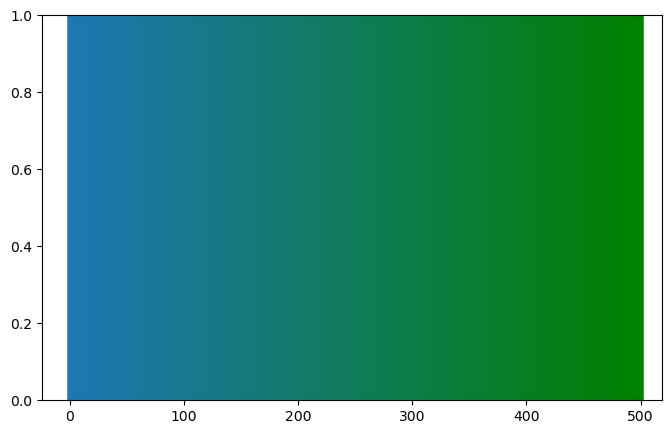

In [160]:
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np

def colorFader(c1,c2,mix=0): #fade (linear interpolate) from color c1 (at mix=0) to c2 (mix=1)
    c1=np.array(mpl.colors.to_rgb(c1))
    c2=np.array(mpl.colors.to_rgb(c2))
    return mpl.colors.to_hex((1-mix)*c1 + mix*c2)

c1='#1f77b4' #blue
c2='green' #green
n=500

fig, ax = plt.subplots(figsize=(8, 5))
for x in range(n+1):
    ax.axvline(x, color=colorFader(c1,c2,x/n), linewidth=4) 
plt.show()

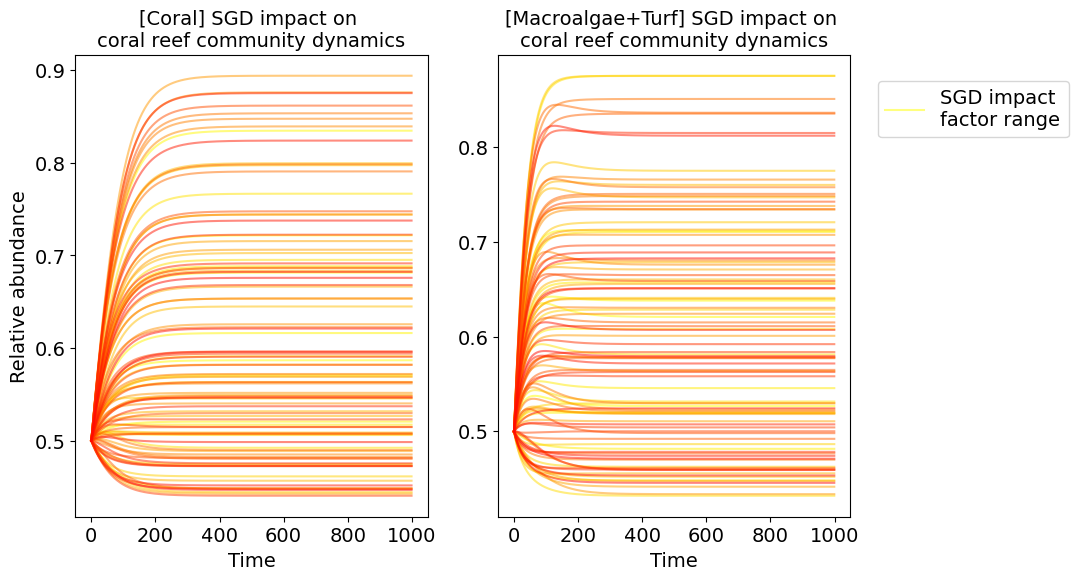

In [189]:
# for loop to create random initial population sizes for both C and M (0 < N < 1)
fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(10,6))

c1='yellow'
c2='red'
n=102

# create empty lists to store sgd impact values in for loop
nC_array = []
nM_array = []

for i in np.arange(0,100):
    # randomize the sgd parameter, while holding starting population size constant
    nC = np.random.random() # populates values b/n 0 and 1 - may need to revisit to get larger or neg values
    nM = np.random.random()
    
    # store random values in lists for sgd parameter impact factors
    nC_array.append(nC)
    nM_array.append(nM)
    
    C_array, M_array = run_model_RK2(C0,M0,parameters_dict)
    
    mycol = colorFader(c1,c2,i/n)
    
    ax1.plot(C_array, c=mycol, alpha = 0.5) # plot the coral time series in plot C
#     ax2.plot(M_array, c='green', alpha = 0.5) # plot the macroalgae time series in plot C
#    ax1.plot(C_array, color=get_color_gradient("#fffc00", "#ff0300", 100), alpha = 0.5) # plot the coral time series in plot C
    ax2.plot(M_array, c=mycol, alpha = 0.5) # plot the macroalgae time series in plot D
    


#ax1.legend(['SGD impact \nfactor range'], loc='lower left', bbox_to_anchor=(-0.75, 0.8), fontsize=14)
ax1.tick_params(axis='x', labelsize=14)
ax1.tick_params(axis='y', labelsize=14)
ax1.set_xlabel("Time", fontsize=14);
ax1.set_ylabel("Relative abundance", fontsize=14);
ax1.set_title('[Coral] SGD impact on \ncoral reef community dynamics', fontsize=14);
# Add colorbar, make sure to specify tick locations to match desired ticklabels




ax2.legend(['SGD impact \nfactor range'], loc='lower left', bbox_to_anchor=(1.05, 0.8), fontsize=14)
ax2.tick_params(axis='x', labelsize=14)
ax2.tick_params(axis='y', labelsize=14)
ax2.set_xlabel("Time", fontsize=14);
#ax2.set_ylabel("Relative abundance", fontsize=14);
ax2.set_title('[Macroalgae+Turf] SGD impact on \ncoral reef community dynamics', fontsize=14);


## need to somehow show the sgd parameter value associated with these outcomes on the plots...
## and/or create a plot showing nC and nM on the y axis, with % cover of C and M on the x shown in respective colors


In [166]:
#nC_array